In [1]:
from sympy import *
import numpy as np
import scipy as sp
import scipy.linalg
import matplotlib.pyplot as plt
import time
from scipy.optimize import minimize
import multiprocessing as mp
from MD_Parser import *

### Define helper functions.

In [15]:
# get two body, one component kernel
# x1, x2 are lists containing the central atom type and chemical environments
# containing distances, Cartesian coordinate differences, and atom types
def tb_kern(x1, x2, d1, d2, sig, ls):
    # loop over atoms
    tot_kern = 0
    
    # record central atom types
    c1 = x1[0][0]
    c2 = x2[0][0]
    
    # get size of environments
    l1 = len(x1[1][0])
    l2 = len(x2[1][0])
    
    for m in range(l1):
        e1 = x1[1][4][m]
        dist1 = x1[1][0][m]
        coord1 = x1[1][d1][m]
        for n in range(l2):
            e2 = x2[1][4][n]
            dist2 = x2[1][0][n]
            coord2 = x2[1][d2][n]
            
            # check that atom types match
            if c1==c2 and e1==e2:
                # calculate covariance for current pair of atoms
                base = sig**2*np.exp(-(dist1-dist2)**2/(2*ls**2))
                doub_fac = -ls**2+(dist1-dist2)**2
                kern = -base*coord1*coord2*doub_fac/(dist1*dist2*ls**4)

                tot_kern+=kern
                
    return tot_kern

# get 3Nx3N noiseless kernel matrix
# assume all 3 force components are known for each configuration
# X is assumed to be a list of environments
def get_K(X,sig,ls,noise):
    # initialize matrix
    size = len(X)*3
    K = np.zeros([size, size])
    
    # calculate elements
    for m in range(size):
        x1 = X[int(floor(m/3))]
        d1 = m%3+1
        for n in range(m,size):
            x2 = X[int(floor(n/3))]
            d2 = n%3+1
           
            # calculate kernel
            cov = tb_kern(x1, x2, d1, d2, sig, ls)
            K[m,n] = cov
            K[n,m] = cov
    # perform cholesky decomposition
    L = np.linalg.cholesky(K+noise**2*np.eye(size))
    
    return K, L

# get row of covariances
def get_cov_row(x1, d1, m, size, X, sig, ls):
    covs = []
    for n in range(m,size):
        x2 = X[int(floor(n/3))]
        d2 = n%3+1

        # calculate kernel
        cov = tb_kern(x1, x2, d1, d2, sig, ls)
        covs.append(cov)
        
    return covs

# get covariance matrix with multiple processors
def get_K_par(X,sig,ls,noise,pool):
    # initialize matrix
    size = len(X)*3
    K = np.zeros([size, size])

    # calculate elements
    results = []
    for m in range(size):
        x1 = X[int(floor(m/3))]
        d1 = m%3+1

        results.append(pool.apply_async(get_cov_row, \
            args=(x1, d1, m, size, X, sig, ls)))

    # construct covariance matrix
    for m in range(size):
        res_cur = results[m].get()
        for n in range(m,size):
            K[m,n]=res_cur[n-m]
            K[n,m]=res_cur[n-m]

    # perform cholesky decomposition
    L = np.linalg.cholesky(K+noise**2*np.eye(size))
    
    return K,L

# get kernel vector
def get_kv(X,x,d1,sig,ls):
    size = len(X)*3
    kv=np.zeros([size,1])
    for m in range(size):
        x2 = X[int(floor(m/3))]
        d2 = m%3+1
        kv[m]=tb_kern(x,x2,d1,d2,sig,ls)
        
    return kv

# get alpha
def get_alpha(K,L,y): 
    # get alpha
    ts1 = sp.linalg.solve_triangular(L,y,lower=True)
    alpha = sp.linalg.solve_triangular(L.transpose(),ts1)
            
    return alpha

# get likelihood
def get_like(K,L,y,alpha): 
    # get log marginal likelihood
    like = -(1/2)*np.matmul(y.transpose(),alpha)-\
            np.sum(np.log(np.diagonal(L)))-\
            np.log(2*np.pi)*K.shape[1]/2
            
    return like

# get likelihood as a function of hyperparameters
def like_hyp(hyp,X,y):
    # unpack hyperparameters
    sig = hyp[0]
    ls = hyp[1]
    noise = hyp[2]
    
    # calculate likelihood
    K, L = get_K(X,sig,ls,noise)
    alpha = get_alpha(K,L,y)
    like = get_like(K,L,y,alpha)
    
    # print
    print('sig: '+str(sig))
    print('ls: '+str(ls))
    print('noise: '+str(noise))
    print('log like: '+str(like))
    
    return like

# get minus likelihood as a function of hyperparameters
def minus_like_hyp(hyp,X,y):
    like = like_hyp(hyp,X,y)
    minus_like = -like
    return minus_like

# make GP prediction with SE kernel
def GP_pred(X,y,K,L,alpha,sig,ls,xt,d):
    # get kernel vector
    kv = get_kv(X,xt,d,sig,ls)
    
    # get predictive mean
    f = np.matmul(kv.transpose(),alpha)
    
    # get predictive variance
    v = sp.linalg.solve_triangular(L,kv,lower=True)
    self_kern = tb_kern(xt, xt, d, d, sig, ls)
    var = self_kern - np.matmul(v.transpose(),v)
    
    return f, var

# given list of Cartesian coordinates, return list of atomic environments
def get_cutoff_vecs(vec, brav_mat, brav_inv, vec1, vec2, vec3, cutoff):
    # get bravais coefficients
    coeff = np.matmul(brav_inv, vec)
    
    # get bravais coefficients for atoms within one super-super-cell
    coeffs = [[],[],[]]
    for n in range(3):
        coeffs[n].append(coeff[n])
        coeffs[n].append(coeff[n]-1)
        coeffs[n].append(coeff[n]+1)
        coeffs[n].append(coeff[n]-2)
        coeffs[n].append(coeff[n]+2)

    # get vectors within cutoff
    vecs = []
    dists = []
    for m in range(len(coeffs[0])):
        for n in range(len(coeffs[1])):
            for p in range(len(coeffs[2])):
                vec_curr = coeffs[0][m]*vec1 + coeffs[1][n]*vec2 + coeffs[2][p]*vec3
                
                dist = np.linalg.norm(vec_curr)

                if dist < cutoff:
                    vecs.append(vec_curr)
                    dists.append(dist)
                    
    return vecs, dists

# given list of cartesian coordinates, get chemical environment of specified atom
# pos = list of cartesian coordinates
# typs = list of atom types
def get_env(pos, typs, atom, brav_mat, brav_inv, vec1, vec2, vec3, cutoff):
    env = [[],[[],[],[],[],[]]]
    pos_atom = np.array(pos[atom]).reshape(3,1)
    typ = typs[atom]
    
    # append central atom type
    env[0].append(typ)
    
    # loop through positions to find all atoms and images in the neighborhood
    for n in range(len(pos)):
        # position relative to reference atom
        diff_curr = np.array(pos[n]).reshape(3,1) - pos_atom

        # get images within cutoff
        vecs, dists = get_cutoff_vecs(diff_curr, brav_mat, \
            brav_inv, vec1, vec2, vec3, cutoff)

        for vec, dist in zip(vecs, dists):
            # ignore self interaction
            if dist != 0:
                # append distance
                env[1][0].append(dist)
                
                # append coordinate differences
                env[1][1].append(-vec[0][0])
                env[1][2].append(-vec[1][0])
                env[1][3].append(-vec[2][0])
                
                # append atom type
                env[1][4].append(typs[n])

    return env

# given list of cartesian coordinates, return list of chemical environments
def get_envs(pos, typs, brav_mat, brav_inv, vec1, vec2, vec3, cutoff):
    envs = []
    for n in range(len(pos)):
        atom = n
        env = get_env(pos, typs, atom, brav_mat, brav_inv, vec1, vec2, vec3, cutoff)
        envs.append(env)
        
    return envs

# convert list of triplets to column vector
def fc_conv(fcs):
    comp_len = len(fcs)*3
    comps = []
    for n in range(comp_len):
        fc_ind = int(floor(n/3))
        d = n%3
        comps.append(fcs[fc_ind][d])
    
    return np.array(comps).reshape(comp_len,1)

# rotate input vector by angle theta
def rotate_xy(x, theta):
    new_x = np.zeros(x.shape)
    for n in range(x.shape[1]):
        vec = x[:,n]
        x_new = np.cos(theta)*vec[1]-np.sin(theta)*vec[2]
        y_new = np.sin(theta)*vec[1]+np.cos(theta)*vec[2]
        new_x[0,n]=x[0,n]
        new_x[1,n]=x_new
        new_x[2,n]=y_new
        new_x[3,n]=x[3,n]
    return new_x

### Parse SiC MD file.

In [3]:
outfile ='/Users/jonpvandermause/Research/GP/Datasets/SiC_MD/sic_md.out'
Si_MD_Parsed = parse_qe_pwscf_md_output(outfile)

In [4]:
# set crystal structure
dim = 3
alat = 4.344404578
unit_cell = [[0.0, alat/2, alat/2], [alat/2, 0.0, alat/2], \
                    [alat/2, alat/2, 0.0]] # fcc primitive cell
unit_pos = [['Si',[0,0,0]],['Si',[alat/4, alat/4, alat/4]]]
brav_mat = np.array([[0.0, alat/2, alat/2], [alat/2, 0.0, alat/2], \
                    [alat/2, alat/2, 0.0]])*dim
brav_inv = np.linalg.inv(brav_mat)

# bravais vectors
vec1 = brav_mat[:,0].reshape(3,1)
vec2 = brav_mat[:,1].reshape(3,1)
vec3 = brav_mat[:,2].reshape(3,1)

In [5]:
# build force field from single snapshot
cutoff = 4.5
pos = Si_MD_Parsed[1]['positions']
typs = Si_MD_Parsed[1]['elements']
envs = get_envs(pos, typs, brav_mat, brav_inv, vec1, vec2, vec3, cutoff)
fcs = fc_conv(Si_MD_Parsed[2]['forces'])

# set hyperparameters
sig = 0.02084984
ls = 0.33739727
noise = 0.00100585

In [151]:
# get K, L, and alpha
K,L=get_K(envs,sig,ls,noise)
alpha=get_alpha(K,L,fcs)

In [152]:
# test on training point
at = 10
d = 1
xt = envs[at]
f, var = GP_pred(envs,fcs,K,L,alpha,sig,ls,xt,d)
print(f)
print(var)

[[0.09325829]]
[[2.5842571e-07]]


In [153]:
# get test environment
test_pt = 50
pos_test = Si_MD_Parsed[test_pt]['positions']
typs_test = Si_MD_Parsed[test_pt]['elements']
envs_test = get_envs(pos_test, typs_test, brav_mat, brav_inv, vec1, vec2, vec3, cutoff)
fcs_test = fc_conv(Si_MD_Parsed[test_pt+1]['forces'])

In [154]:
# test on all components in the test point
errs = []
stds = []
f_preds = []
f_ts = []
force_conv = 25.71104309541616 # Ry/au to eV/A
for m in range(54):
    at = m
    for n in range(3):
        d=n+1
        xt = envs_test[at]
        
        f, var = GP_pred(envs,fcs,K,L,alpha,sig,ls,xt,d)
        f_true = fcs_test[int(at*3+d-1)][0]*force_conv
        f_pred = f[0][0]*force_conv
        std_pred = np.sqrt(var[0][0])*force_conv
        err_true = np.abs(f_true-f_pred)
        
        errs.append(err_true)
        stds.append(std_pred)
        f_preds.append(f_pred)
        f_ts.append(f_true)
        
    print(m)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53


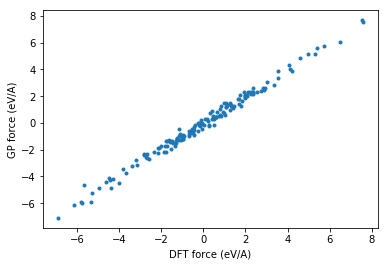

In [155]:
# plot GP versus DFT force
plt.plot(f_ts, f_preds, '.')
plt.xlabel('DFT force (eV/A)')
plt.ylabel('GP force (eV/A)')
plt.show()

In [156]:
print('mean error is '+str(np.mean(errs))+' eV.')

mean error is 0.216603803883534 eV.


In [157]:
noise*force_conv

0.025861452697524344

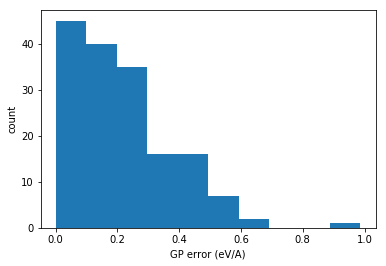

In [158]:
plt.hist(errs)
plt.xlabel('GP error (eV/A)')
plt.ylabel('count')
plt.show()

In [160]:
np.mean(np.abs(f_ts))

2.0335634855198093

### Construct different force models for different atom types.

#### Change envs data structure: organize by atom type.

The new list of environments is structured as follows: [[list of atom 1 environments], ..., [list of atom N environments]]

In [75]:
# given a list of chemical environments, count the number of atoms of a given type
def count_type(X,typ):
    typ_count = 0
    
    for n in range(len(X)):
        env_curr = X[n]
        typ_curr = env_curr[0][0]
        
        if typ_curr == typ:
            typ_count+=1
    
    return typ_count

# given a list of chemical environments, count the number of different atom types
def count_types(X):
    typ_list = []
    typ_count = 0
    for n in range(len(X)):
        env_curr = X[n]
        typ_curr = env_curr[0][0]
        
        if typ_curr not in typ_list:
            typ_list.append(typ_curr)
            typ_count +=1
            
    return typ_count

# given a list of atom types, count the number of distinct kinds
def count_kinds(typs):
    typ_list = []
    typ_count = 0
    for n in range(len(typs)):
        typ_curr = typs[n]
        
        if typ_curr not in typ_list:
            typ_list.append(typ_curr)
            typ_count+=1
            
    return typ_count, typ_list

# initialize list of environments
def init_envs(typs):
    # count atom types
    typ_count, typ_list = count_kinds(typs)
    
    # initialize envs
    envs_init = []
    for n in range(typ_count):
        envs_init.append([])
    
    return envs_init, typ_list

# initialize list of environments and forces
def init_envs_fcs(typs):
    # count atom types
    typ_count, typ_list = count_kinds(typs)
    
    # initialize envs
    envs_init = []
    fcs_init = []
    for n in range(typ_count):
        envs_init.append([])
        fcs_init.append([])
    
    return envs_init, typ_list, fcs_init

# get type index
def get_typ_ind(typ,typ_list):
    typ_ind = -1
    for n in range(len(typ_list)):
        typ_curr = typ_list[n]
        if typ_curr == typ:
            typ_ind = n
    return typ_ind
        
# given list of cartesian coordinates, return list of chemical environments
def get_envs_typ(pos, typs, brav_mat, brav_inv, vec1, vec2, vec3, cutoff):
    envs, typ_list = init_envs(typs)
    for n in range(len(pos)):
        atom = n
        env = get_env(pos, typs, atom, brav_mat, brav_inv, vec1, vec2, vec3, cutoff)
        
        # get type and type index and append environment
        typ = typs[n]
        typ_ind = get_typ_ind(typ, typ_list)
        envs[typ_ind].append(env)
        
    return envs

In [46]:
# test envs function
cutoff = 4.5
pos = Si_MD_Parsed[1]['positions']
typs = Si_MD_Parsed[1]['elements']
envs = get_envs_typ(pos, typs, brav_mat, brav_inv, vec1, vec2, vec3, cutoff)
fcs = fc_conv(Si_MD_Parsed[2]['forces'])

#### Modify K function to take atom type as input.

In [69]:
def get_X_ind(X,typ):
    ind = -1
    for n in range(len(X)):
        envs_curr = X[n]
        if typ == envs_curr[0][0][0]:
            ind = n
    return ind

# get environment list for given atom type
def get_envs_X(X,typ):
    ind = get_X_ind(X,typ)
    envs = X[ind]
    return envs

#### Organize forces by atom type.

In [111]:
# given list of cartesian coordinates, return list of chemical environments
def envs_fcs_by_typ(pos, fcs_in, typs, brav_mat, brav_inv, vec1, vec2, vec3, cutoff):
    envs, typ_list, fcs = init_envs_fcs(typs)
    for n in range(len(pos)):
        atom = n
        env = get_env(pos, typs, atom, brav_mat, brav_inv, vec1, vec2, vec3, cutoff)
        
        # get type and type index and append environment
        typ = typs[n]
        typ_ind = get_typ_ind(typ, typ_list)
        envs[typ_ind].append(env)
        
        # append force components
        fcs_curr = fcs_in[n]
        for m in range(3):
            fcs[typ_ind].append(fcs_curr[m])
            
    return envs, fcs

In [87]:
# test envs function
cutoff = 4.5
pos = Si_MD_Parsed[1]['positions']
typs = Si_MD_Parsed[1]['elements']
fcs_in = Si_MD_Parsed[2]['forces']
envs, fcs = envs_fcs_by_typ(pos, fcs_in, typs, brav_mat, brav_inv, vec1, vec2, vec3, cutoff)

#### Write helper functions for hyperparameter optimization on the cluster.

In [114]:
# set hyperparameters
# sig = 0.02084984
# ls = 0.33739727
# noise = 0.00100585

sig = 1
ls = 1
noise = 0.01

# minimize minus log likelihood using Nelder-Mead
x0 = np.array([sig,ls,noise])
envs_test = envs[0]
fcs_test = np.array(fcs[0]).reshape(len(fcs[0]),1)
args = (envs_test,fcs_test)
res = minimize(minus_like_hyp, x0, args, method='nelder-mead', \
               options={'xtol': 1e-8, 'disp': True})

print(res.x)

sig: 1.0
ls: 1.0
noise: 0.01
log like: [[169.2335843]]
sig: 1.05
ls: 1.0
noise: 0.01
log like: [[169.56398673]]
sig: 1.0
ls: 1.05
noise: 0.01
log like: [[167.07018438]]
sig: 1.0
ls: 1.0
noise: 0.0105
log like: [[171.1525863]]
sig: 1.0333333333333332
ls: 0.95
noise: 0.010333333333333332
log like: [[171.75367219]]
sig: 1.0499999999999998
ls: 0.8999999999999999
noise: 0.010499999999999999
log like: [[172.33944416]]
sig: 1.0666666666666664
ls: 0.9333333333333333
noise: 0.010666666666666666
log like: [[172.83136052]]
sig: 1.0999999999999996
ls: 0.8999999999999999
noise: 0.011
log like: [[173.31347415]]
sig: 1.0499999999999996
ls: 0.8666666666666665
noise: 0.011333333333333332
log like: [[173.63944136]]
sig: 1.0499999999999994
ls: 0.7999999999999998
noise: 0.012
log like: [[172.29955314]]
sig: 1.1333333333333329
ls: 0.7777777777777775
noise: 0.011388888888888884
log like: [[169.81599924]]
sig: 1.0333333333333332
ls: 0.9444444444444444
noise: 0.010722222222222222
log like: [[172.95155281]]
si

sig: 0.34723022274952575
ls: 0.6671739815541458
noise: 0.012428584338846426
log like: [[176.93038423]]
sig: 0.36140925587738154
ls: 0.719930047568279
noise: 0.012580790188474578
log like: [[177.25451526]]
sig: 0.2850843230048553
ls: 0.6782012368619537
noise: 0.012314301462864108
log like: [[177.46222087]]
sig: 0.22686018333240554
ls: 0.65536940149972
noise: 0.012131551652301363
log like: [[177.09175567]]
sig: 0.2743243808955446
ls: 0.6543168897425455
noise: 0.012235653207972149
log like: [[177.44232634]]
sig: 0.2627396320276002
ls: 0.6595557144610267
noise: 0.012474327883315203
log like: [[177.57272604]]
sig: 0.22734637043869355
ls: 0.6440628268880917
noise: 0.012561726529438919
log like: [[177.49440117]]
sig: 0.314218240425506
ls: 0.6992728641376986
noise: 0.01269732171663953
log like: [[177.41040462]]
sig: 0.28429784577803496
ls: 0.6655558833413338
noise: 0.012351070335138995
log like: [[177.52255011]]
sig: 0.21975789025787318
ls: 0.642914210278823
noise: 0.012148966746807332
log lik

sig: 0.2599191655553507
ls: 0.6557469973013741
noise: 0.01284373103925086
log like: [[177.62773331]]
sig: 0.25990476733780576
ls: 0.6557331029619096
noise: 0.012844520191046871
log like: [[177.62773345]]
sig: 0.25993647931876585
ls: 0.6557595822039896
noise: 0.01284450277242238
log like: [[177.62773345]]
sig: 0.25995896926002493
ls: 0.6557779867297606
noise: 0.012844646667881987
log like: [[177.62773333]]
sig: 0.2598897486387044
ls: 0.6557368354982771
noise: 0.012844546286499656
log like: [[177.62773342]]
sig: 0.2599255845076449
ls: 0.655747567471938
noise: 0.012844364563693277
log like: [[177.62773347]]
sig: 0.25994488311205505
ls: 0.6557542164823038
noise: 0.012844672567691392
log like: [[177.62773338]]
sig: 0.25991097402608077
ls: 0.6557430180777666
noise: 0.012844357479735566
log like: [[177.62773347]]
sig: 0.2599439245638553
ls: 0.6557670088738865
noise: 0.012844296352853946
log like: [[177.62773342]]
sig: 0.2599145566443182
ls: 0.6557415794399037
noise: 0.01284446423149864
log li

KeyboardInterrupt: 

In [115]:
sig = 0.2599181503936895
ls = 0.6557459558098258
noise = 0.012844399430797954

# minimize minus log likelihood using Nelder-Mead
x0 = np.array([sig,ls,noise])
envs_test = envs[1]
fcs_test = np.array(fcs[1]).reshape(len(fcs[1]),1)
args = (envs_test,fcs_test)
res = minimize(minus_like_hyp, x0, args, method='nelder-mead', \
               options={'xtol': 1e-8, 'disp': True})

print(res.x)

sig: 0.2599181503936895
ls: 0.6557459558098258
noise: 0.012844399430797954
log like: [[187.40455704]]
sig: 0.272914057913374
ls: 0.6557459558098258
noise: 0.012844399430797954
log like: [[187.51983422]]
sig: 0.2599181503936895
ls: 0.688533253600317
noise: 0.012844399430797954
log like: [[186.61051827]]
sig: 0.2599181503936895
ls: 0.6557459558098258
noise: 0.013486619402337852
log like: [[186.31161355]]
sig: 0.2685820887401458
ls: 0.6776041543368199
noise: 0.012202179459258056
log like: [[188.13584215]]
sig: 0.272914057913374
ls: 0.6885332536003168
noise: 0.011559959487718159
log like: [[188.64707039]]
sig: 0.2772460270866022
ls: 0.6448168565463286
noise: 0.011988106135411422
log like: [[188.80839872]]
sig: 0.2859099654330586
ls: 0.6229586580193343
noise: 0.011559959487718156
log like: [[189.02523227]]
sig: 0.29457390377951487
ls: 0.6557459558098255
noise: 0.011131812840024893
log like: [[189.92291388]]
sig: 0.31190178047242756
ls: 0.6557459558098255
noise: 0.010275519544638363
log like

sig: 0.49549358069583904
ls: 0.7399956086692798
noise: 0.00986149871437951
log like: [[191.06111518]]
sig: 0.49527004174119915
ls: 0.7394467189407918
noise: 0.009848500658859376
log like: [[191.06091821]]
sig: 0.4964698242817038
ls: 0.7403716467286552
noise: 0.009870506738224507
log like: [[191.06113391]]
sig: 0.49164431575639134
ls: 0.7386899267399529
noise: 0.009860970935670232
log like: [[191.0609453]]
sig: 0.49707499122461485
ls: 0.7404305123900365
noise: 0.009865812074925824
log like: [[191.06114611]]
sig: 0.49886137090669336
ls: 0.7413481490698899
noise: 0.0098712887187687
log like: [[191.060971]]
sig: 0.4950885126477321
ls: 0.739724809359041
noise: 0.00986326440438057
log like: [[191.06114891]]
sig: 0.49692863807352805
ls: 0.7403557036492086
noise: 0.009871556763974425
log like: [[191.06115068]]
sig: 0.4976461667623726
ls: 0.740535751139173
noise: 0.009876585788771881
log like: [[191.06109357]]
sig: 0.49625827034887954
ls: 0.7399690368702023
noise: 0.00986324875729604
log like: 

KeyboardInterrupt: 